# DC Power estimation

<table>
  <tr>
    <td><img src="https://raw.githubusercontent.com/AlexandreHugoMathieu/pvfault_detection_solar_academy/refs/heads/master/notebooks/logos/CSTB_logo.jpg" width="200" />
    <td><img src="https://raw.githubusercontent.com/AlexandreHugoMathieu/pvfault_detection_solar_academy/refs/heads/master/notebooks/logos/Heliocity_logo.png" width="200" /> 
    <td><img src="https://raw.githubusercontent.com/AlexandreHugoMathieu/pvfault_detection_solar_academy/refs/heads/master/notebooks/logos/USMB_logo_horizontal.png" width="200" />
  </tr>
</table>

<sub>Author: Alexandre MATHIEU, Phd Student, in collaboration Heliocity / CSTB / USMB (LOCIE). </sub>
<sub>Phd thesis: Methodology development to guarantee building photovoltaic systems' performance including failure modelling</sub>

This notebook introduces some tools to model the DC power production of a PV installation.

It is broken down into three parts:

1. **Data visualization**: Exploration of weather and PV data
2. **POA irradiance, temperature, and Power modeling**: Estimation temperature/DC power and comparison to real values.
3. **PR calculation**

The attendees are very much welcome to modify and create/execute some new notebook cells to explore data and try out new methods.

The two first parts are used to introduce the subject and the attendees are expected to collaborate and develop detection methods in the part 3. 

**Make sure to manually execute the cells (ctrl + enter) yourself one by one**

Data: Scenario 1 from the 2021 PVPMC blind comparison

##### Caracteristics of the PV installation:
- 12 modules in series

#####  Module datasheet
- 325 Wp
- Thermal (power) coefficient: -2.58 % /°C 
- NOCT: 43 °C

#####  Generic temperature oefficients for open-rack PV installation
- u_0 = 26.9 W/(˚C.m2)
- u_1 = 6.2 W.s/(˚C.m3)

## I. Data vizualization

In [1]:
# Please execute this cell to import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## I.1. In-situ weather data

Below is the weather inputs of the models to estimate the DC production.

In [2]:
# Load satellite weather data: incident irradiation, direct irradiation, temperature, wind from online file
url="https://raw.githubusercontent.com/AlexandreHugoMathieu/pvfault_detection_solar_academy/refs/heads/master/data/xtrain.csv"
weather_data = pd.read_csv(url, index_col=0) 
weather_data.index = pd.to_datetime(weather_data.index)
print(weather_data.head(10))

                                  ghi        dhi         dni  temp_air  \
2020-01-01 01:00:00-07:00    0.000000   0.000000    0.000000  0.000000   
2020-01-01 02:00:00-07:00    0.000000   0.000000    0.000000  0.000000   
2020-01-01 03:00:00-07:00    0.000000   0.000000    0.000000  0.000000   
2020-01-01 04:00:00-07:00    0.000000   0.000000    0.000000  0.000000   
2020-01-01 05:00:00-07:00    0.000000   0.000000    0.000000  0.000000   
2020-01-01 06:00:00-07:00    0.000000   0.000000    0.000000  0.000000   
2020-01-01 07:00:00-07:00    0.000000   0.000000    0.000000  0.000000   
2020-01-01 08:00:00-07:00   40.874978  14.742914  264.832939 -4.737162   
2020-01-01 09:00:00-07:00  185.738601  31.546335  754.498236 -3.652383   
2020-01-01 10:00:00-07:00  353.666975  40.138926  914.471581 -0.708700   

                           wind_speed  sun_azimuth  sun_elevation  
2020-01-01 01:00:00-07:00    0.000000    45.887005     -73.699678  
2020-01-01 02:00:00-07:00    0.000000    60.33037

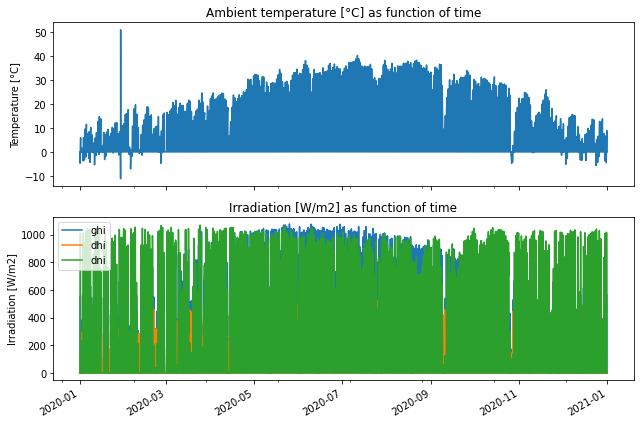

In [3]:
# Make a figure with two axes (two figures top/bottom) which share the same x axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9,6), sharex=True) 


# Show the Ambient temperature on the first axis
weather_data["temp_air"].plot(ax=ax1, title="Ambient temperature [°C] as function of time",ylabel="Temperature [°C]")

# Show the three irradiance components on the second axis [GHI, DHI, DNI]
meteo_plot = weather_data[["ghi","dhi", "dni"]] # Get the three relevant columns from the dataframe
meteo_plot.plot(ax=ax2, title="Irradiation [W/m2] as function of time", ylabel="Irradiation [W/m2]")

plt.tight_layout() # Resize automatically the figure to make it *pretty*

## II. DC power estimation

Modeling PV power from ghi/dhi/dni goes into three steps:

1. Modeling the POA irradiance.
2. Modeling the module cell temperature. 
3. Modeling the installation power production.
4. Modeling the installation inverter efficiency.


### II.1. POA irradiance

In [4]:
# Installation orientation
beta = 35 # tilt [°]
azimuth = 180 # azimuth [°]
rho = 0.2 # Albedo [-]

#### Exercice

Calculate the POA irradiance with the no-shading/isotropic assumption as introduced in the notebook "python_intro_poa"

In [5]:
# The lazy way with the pvlib package
from pvlib.irradiance import get_total_irradiance

# Notice it takes degrees as inputs
poa_data = get_total_irradiance(beta, azimuth, 90-weather_data["sun_elevation"], weather_data["sun_azimuth"],
                                weather_data["dni"], weather_data["ghi"], weather_data["dhi"], albedo=rho)
poa_data.head(12) # Show first 12 lines

,poa_global,poa_direct,poa_diffuse,poa_sky_diffuse,poa_ground_diffuse
2020-01-01 01:00:00-07:00,0.000000,-0.000000,0.000000,0.000000,0.000000
2020-01-01 02:00:00-07:00,0.000000,-0.000000,0.000000,0.000000,0.000000
2020-01-01 03:00:00-07:00,0.000000,-0.000000,0.000000,0.000000,0.000000
2020-01-01 04:00:00-07:00,0.000000,-0.000000,0.000000,0.000000,0.000000
2020-01-01 05:00:00-07:00,0.000000,-0.000000,0.000000,0.000000,0.000000
2020-01-01 06:00:00-07:00,0.000000,-0.000000,0.000000,0.000000,0.000000
2020-01-01 07:00:00-07:00,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-01 08:00:00-07:00,98.965639,84.816622,14.149017,13.409801,0.739216
2020-01-01 09:00:00-07:00,432.922776,400.869941,32.052835,28.693790,3.359045
2020-01-01 10:00:00-07:00,689.575320,646.669920,42.905400,36.509405,6.395995


### II.2. Cell temperature model

#### Exercice

Calculate the module temperature with, both, the Ross or Faiman model

In [6]:
# Develop your code here

### II.3. DC power model

#### Exercice

Calculate the DC power with the PVwatts or Huld model

In [7]:
# Develop your code here

### II.4. AC power model



#### Exercice

Calculate the AC power with the PVWatts inverter model (create a function for that purpose !)

In [ ]:
# Develop your code here

### III. Performance Ratio calculation

In [ ]:
# Load actual data
actual = pd.read_csv(DATA_PATH / "ytrain.csv", index_col=0) 
actual.index = pd.to_datetime(actual.index)
print(actual.head(10))

#### Exercice

Calculate the PR and the Energy Performance Index

In [9]:
# Develop your code here

In [ ]:
# Develop your code here

#### Exercice, to go further 

- What is the accuracy of the values compared to the real values imported below ? 

Calculate the Mean Error and Mean Absolute Error

In [12]:
# Develop your code here

In [ ]:
# Develop your code here